# DS4H - P2 Exploratory Data Analysis

CS 189: Data Science For Health  
Dartmouth College  
Spring 2022  

Franklin, Ke, Spencer

To run this notebook, place the data files into a directory called 'data' that sits at the same location as this jupyter notebook. 

Data Source: [CDC National Center for Health Statistics](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire&CycleBeginYear=2013)

# Imports

In [8]:
# Note: 
# If the theme of jupyter lab is in "Dark Mode" you won't be able to see the axis labels
# TO CHANGE THEME --> Settings --> Theme --> JupyterLab (Light/Dark)

from pathlib import Path 
from typing import Dict
import os

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
from matplotlib_venn import venn2
plt.style.use("fivethirtyeight")
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import seaborn as sns

# Load the data using pandas

In [12]:
p: str = os.path.abspath('')
base_path: str = p[:-10] + '/data/'
print(f'Data files should be in the following directory: {base_path}')

Data files should be in the following directory: /Users/spencerbertsch/Desktop/dev/DS4H/data/


#### Load the physical activity data

In [14]:
df_active_path: str = base_path + 'PAXDAY_H.XPT'
df_active: pd.DataFrame = pd.read_sas(df_active_path)
df_active.head(5)

,SEQN,PAXDAYD,PAXDAYWD,PAXSSNDP,PAXMSTD,PAXTMD,PAXAISMD,PAXVMD,PAXMTSD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXLXSD,PAXQFD
0,73557.0,b'1',b'3',5.397605e-79,b'16:30:00',450.0,915200.0,450.0,4576.422,2.370000e+02,2.200000e+01,174.0,17.0,1.470493e+05,5.397605e-79
1,73557.0,b'2',b'4',2.160000e+06,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,7.440000e+02,1.130000e+02,546.0,37.0,1.733408e+05,5.397605e-79
2,73557.0,b'3',b'5',9.072000e+06,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,1.470000e+02,5.397605e-79,1287.0,6.0,8.340733e+04,5.397605e-79
3,73557.0,b'4',b'6',1.598400e+07,b' 0:00:00',1440.0,6860400.0,1440.0,23.641,5.397605e-79,5.397605e-79,1439.0,1.0,5.397605e-79,5.397605e-79
4,73557.0,b'5',b'7',2.289600e+07,b' 0:00:00',1440.0,3968640.0,1440.0,8879.010,5.040000e+02,9.800000e+01,822.0,16.0,3.864985e+04,5.397605e-79


#### Load the sleep data

In [15]:
df_sleep_path: str = base_path + 'SLQ_H.XPT'
df_sleep: pd.DataFrame = pd.read_sas(df_sleep_path)
df_sleep.head(5)

,SEQN,SLD010H,SLQ050,SLQ060
0,73557.0,7.0,1.0,2.0
1,73558.0,9.0,2.0,2.0
2,73559.0,8.0,2.0,2.0
3,73561.0,9.0,2.0,2.0
4,73562.0,5.0,2.0,1.0


# Initial Processing and Data Observation

We can immediately see some light processing that we need to apply to use this data including the fact that the values in the physical activity data can be as small as 5.397605e-79, meaning that we need to round these values to some reasonable digit before continuing. 

In [17]:
df_active = round(df_active, 6)
df_active.head(5)

,SEQN,PAXDAYD,PAXDAYWD,PAXSSNDP,PAXMSTD,PAXTMD,PAXAISMD,PAXVMD,PAXMTSD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXLXSD,PAXQFD
0,73557.0,b'1',b'3',0.0,b'16:30:00',450.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,147049.33,0.0
1,73557.0,b'2',b'4',2160000.0,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,173340.75,0.0
2,73557.0,b'3',b'5',9072000.0,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,147.0,0.0,1287.0,6.0,83407.33,0.0
3,73557.0,b'4',b'6',15984000.0,b' 0:00:00',1440.0,6860400.0,1440.0,23.641,0.0,0.0,1439.0,1.0,0.00,0.0
4,73557.0,b'5',b'7',22896000.0,b' 0:00:00',1440.0,3968640.0,1440.0,8879.010,504.0,98.0,822.0,16.0,38649.85,0.0


# Question 1

### How many of the patients belong to both of the data sets? 

We can answer this question by creating a venn diagram showing the number of patients that belong to each of the sets. 

In [19]:
physical_activity_patient_ids: set = set(df_active['SEQN'])

In [20]:
sleep_patient_ids: set = set(df_sleep['SEQN'])

In [21]:
def create_venn_2_sets(set1: set, set2: set, set1_name: str, set2_name: str):
    """
    This function can be used to create a venndiagram using two distinct sets of values. This function can be extended easily using the 'venn3' 
    library built using Matplotlib so that venn diagrams of 3 sets can be generated. 
    """
    figure(figsize=(6, 6), dpi=80)
    venn2([set1, set2], 
          (set1_name, set2_name), 
          set_colors=('purple', 'skyblue'), 
          alpha = 0.7)
    plt.show()

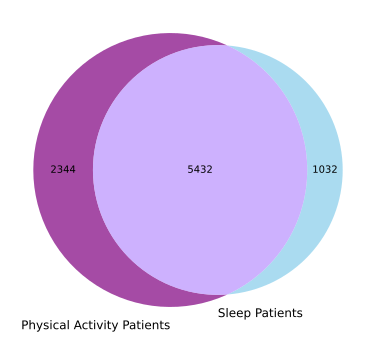

In [22]:
create_venn_2_sets(set1=physical_activity_patient_ids, set2=sleep_patient_ids, set1_name='Physical Activity Patients', set2_name='Sleep Patients')

This venn diagram shows us the set intersection betwen the patients included in each of the data sets that we're going to use. Our goal here is to combine the physical activity data and teh sleep data together, but we can only perform the join on **patient_id**. This plot shows us that even though we are losing 2,344 physical activity patients who don't have sleep data and 1,032 sleep patents who don't have physical activity data, we still have 5,432 patients to use in our analysis. 

## Join the physical activity and sleep data together 

At this point we can now perform an inner join to merge these two data sets together

In [25]:
df_joined = df_active.merge(df_sleep, left_on='SEQN', right_on='SEQN')
df_joined.head()

,SEQN,PAXDAYD,PAXDAYWD,PAXSSNDP,PAXMSTD,PAXTMD,PAXAISMD,PAXVMD,PAXMTSD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXLXSD,PAXQFD,SLD010H,SLQ050,SLQ060
0,73557.0,b'1',b'3',0.0,b'16:30:00',450.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,147049.33,0.0,7.0,1.0,2.0
1,73557.0,b'2',b'4',2160000.0,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,173340.75,0.0,7.0,1.0,2.0
2,73557.0,b'3',b'5',9072000.0,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,147.0,0.0,1287.0,6.0,83407.33,0.0,7.0,1.0,2.0
3,73557.0,b'4',b'6',15984000.0,b' 0:00:00',1440.0,6860400.0,1440.0,23.641,0.0,0.0,1439.0,1.0,0.00,0.0,7.0,1.0,2.0
4,73557.0,b'5',b'7',22896000.0,b' 0:00:00',1440.0,3968640.0,1440.0,8879.010,504.0,98.0,822.0,16.0,38649.85,0.0,7.0,1.0,2.0


In [36]:
valid_patient_ids: int = len(physical_activity_patient_ids) - len(physical_activity_patient_ids - sleep_patient_ids)
print(f'We can see that the resulting data frame has {df_joined.shape[0]} records resulting from the {valid_patient_ids} patients that each have around one week\'s worth of physical activity data.')

We can see that the resulting data frame has 48356 records resulting from the 5432 patients that each have around one week's worth of physical activity data.


# TODO use a dictionary to rename all the columns

In [48]:
renamer: dict = {'SEQN': 'patient_id', ...}

# Question 2

### How are the physical activity measurements correlated to the sleep values across patients? 

We can answer this question by grouping each cluster of physical activity values to get the mean value for each patient, then generating a correlation matrix to see how each fearure is correlated with the sleep featuers. 

In [43]:
df_grouped: pd.DataFrame = df_joined.groupby('SEQN').mean()
df_grouped.head()

,PAXSSNDP,PAXTMD,PAXAISMD,PAXVMD,PAXMTSD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXLXSD,PAXQFD,SLD010H,SLQ050,SLQ060
SEQN,,,,,,,,,,,,,,
73557.0,23424000.0,1281.0,3.997156e+06,1281.000000,6369.495333,350.777778,82.777778,833.555556,13.888889,108972.836667,0.000000,7.0,1.0,2.0
73558.0,22144000.0,1281.0,2.742481e+06,1280.666667,8307.157778,678.555556,383.333333,158.000000,60.777778,64439.798889,0.333333,9.0,2.0,2.0
73559.0,24448000.0,1281.0,3.228436e+06,1281.000000,8005.963333,658.888889,511.111111,43.555556,67.444444,279876.924444,0.000000,8.0,2.0,2.0
73561.0,24448000.0,1281.0,2.305937e+06,1280.666667,6470.660889,680.111111,501.000000,25.777778,73.777778,65044.487778,0.333333,9.0,2.0,2.0
73562.0,23168000.0,1281.0,2.637164e+06,1279.666667,14613.943222,836.333333,385.111111,0.000000,58.222222,20804.137778,1.333333,5.0,2.0,1.0


Now that we have the grouped dataframe we can generate the correlation matrix and use a heatmap to visualize it. 

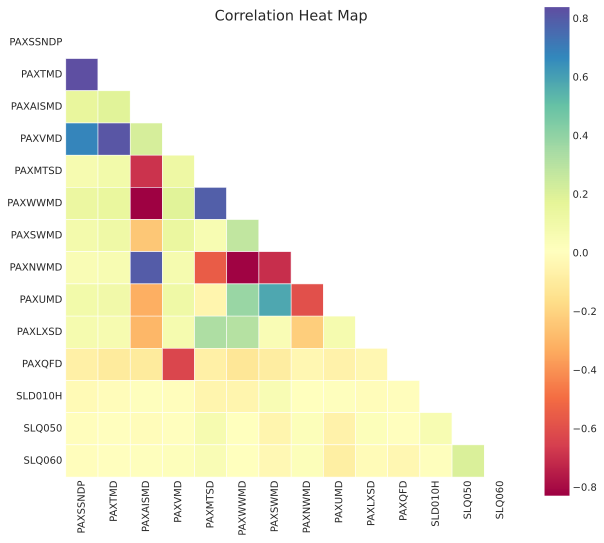

In [65]:
corr = df_grouped.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(corr, mask=mask, square=True, cmap="Spectral", linewidths=0.5).set_title('Correlation Heat Map')

Some of the physical acti

We know that each patient has a week's worth of time series physical activity data, so we can also plot a few of the samples to see what they look like.

In [53]:
single_patient_df: pd.DataFrame = df_joined[df_joined['SEQN'] == 73557.0]
single_patient_df

,SEQN,PAXDAYD,PAXDAYWD,PAXSSNDP,PAXMSTD,PAXTMD,PAXAISMD,PAXVMD,PAXMTSD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXLXSD,PAXQFD,SLD010H,SLQ050,SLQ060
0,73557.0,b'1',b'3',0.0,b'16:30:00',450.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,147049.33,0.0,7.0,1.0,2.0
1,73557.0,b'2',b'4',2160000.0,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,173340.75,0.0,7.0,1.0,2.0
2,73557.0,b'3',b'5',9072000.0,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,147.0,0.0,1287.0,6.0,83407.33,0.0,7.0,1.0,2.0
3,73557.0,b'4',b'6',15984000.0,b' 0:00:00',1440.0,6860400.0,1440.0,23.641,0.0,0.0,1439.0,1.0,0.00,0.0,7.0,1.0,2.0
4,73557.0,b'5',b'7',22896000.0,b' 0:00:00',1440.0,3968640.0,1440.0,8879.010,504.0,98.0,822.0,16.0,38649.85,0.0,7.0,1.0,2.0
5,73557.0,b'6',b'1',29808000.0,b' 0:00:00',1440.0,4450080.0,1440.0,10569.811,547.0,65.0,816.0,12.0,324140.55,0.0,7.0,1.0,2.0
6,73557.0,b'7',b'2',36720000.0,b' 0:00:00',1440.0,3826400.0,1440.0,11309.860,628.0,193.0,611.0,8.0,72590.42,0.0,7.0,1.0,2.0
7,73557.0,b'8',b'3',43632000.0,b' 0:00:00',1440.0,5132161.0,1440.0,6284.301,336.0,46.0,1046.0,12.0,141456.06,0.0,7.0,1.0,2.0
8,73557.0,b'9',b'4',50544000.0,b' 0:00:00',999.0,4523760.0,999.0,301.339,14.0,208.0,761.0,16.0,121.24,0.0,7.0,1.0,2.0


In [76]:
def plot_physical_activity_for_single_patient(signals_to_plot: list):
    fig, axs = plt.subplots(4, figsize=(12, 9))
    fig.suptitle('Physical Activity Signals for a Single Patient', fontsize=17)

    axs[0].plot(single_patient_df.index, single_patient_df[signals_to_plot[0]], color='blue')
    axs[1].plot(single_patient_df.index, single_patient_df[signals_to_plot[1]], color='darkorange')
    axs[2].plot(single_patient_df.index, single_patient_df[signals_to_plot[2]], color='blue')
    axs[3].plot(single_patient_df.index, single_patient_df[signals_to_plot[3]], color='orange')

    for i, ax in enumerate(axs.flat):
        ax.set(ylabel=signals_to_plot[i])

    ax.set(xlabel='Time (Day of the week)')

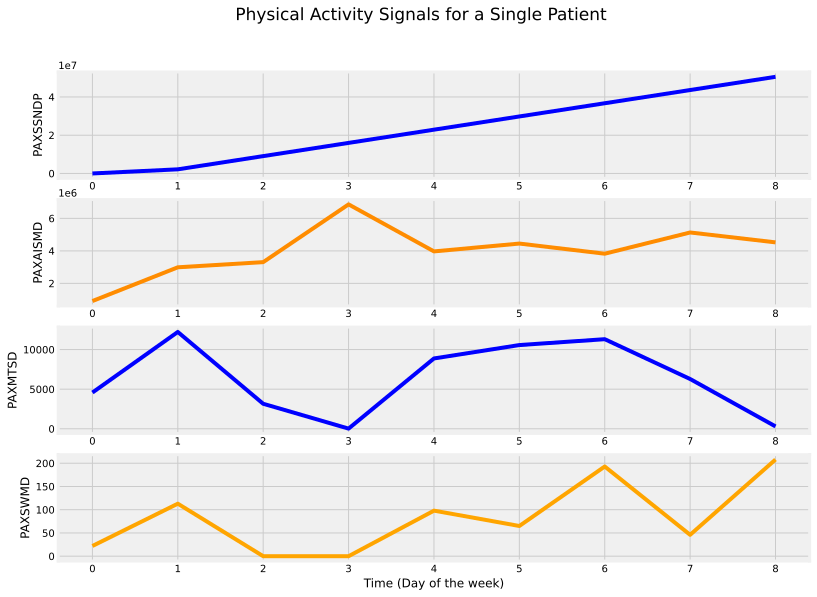

In [77]:
plot_physical_activity_for_single_patient(signals_to_plot = ['PAXSSNDP', 'PAXAISMD', 'PAXMTSD', 'PAXSWMD'])

We can see here that each time series presents a unique signal, giving us a 